In [ ]:
# ! pip install -q -U huggingface_hub

In [1]:
from huggingface_hub import login

login()

In [ ]:
! pip install -U ipywidgets



In [ ]:
! pip install ipywidgets

In [1]:
import pprint
from pathlib import Path
from typing import cast

import matplotlib.pyplot as plt
import torch
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)
from colpali_engine.models import ColPali, ColPaliProcessor
from colpali_engine.utils.torch_utils import get_torch_device
from PIL import Image

In [2]:
def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    调整后的 H 为1024
    该函数的作用是将图像缩放到新高度，同时保持其宽高比
    """
    # Calculate the scaling factor
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    # Resize the image
    scaled_image = image.resize((new_width, new_height))

    return scaled_image,width,height,new_height,new_width


In [3]:
model_name = "/huggingface/models/vidore/colpali-v1.2-merged"

device = get_torch_device("auto")
print(f"Using device: {device}")

# Load the model
model = cast(
    ColPali,
    ColPali.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map=device,
    ),
).eval()

# Load the processor
processor = cast(ColPaliProcessor, ColPaliProcessor.from_pretrained(model_name))

Using device: cuda:0


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# ==========================     USER INPUTS     ==========================

image_filepath = Path("/Data/shift_kazakhstan.jpeg")
query = "Quelle partie de la production pétrolière du Kazakhstan provient de champs en mer ?"
# 哈萨克斯坦的石油生产中有多少来自海上油田？
# =========================================================================
# 检查文件是否有效，并且查询是否为空
assert image_filepath.is_file(), f"Cannot find the image file at `{image_filepath}`"
assert query, "Please write down your query."

image = Image.open(image_filepath)

# Preview the image   将图像缩放到高度为 512 像素
scale_image(image, 512)

(<PIL.Image.Image image mode=RGB size=454x512>, 1113, 1255, 512, 454)

In [6]:
# Preprocess inputs
batch_images = processor.process_images([image]).to(device)
batch_queries = processor.process_queries([query]).to(device)

# Forward passes
with torch.no_grad():
    image_embeddings = model.forward(**batch_images)
    query_embeddings = model.forward(**batch_queries)

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


In [7]:
# Get the number of image patches
n_patches = processor.get_n_patches(image_size=image.size, patch_size=model.patch_size)

print(f"Number of image patches: {n_patches}")

# Get the tensor mask to filter out the embeddings that are not related to the image
image_mask = processor.get_image_mask(batch_images)
# 一共划分了1024块，经过调整后的图像像素为454/512，占比大约是0.8869，所以极有可能是 W 进行填充，然后变成512×512，patch_size是16，最后变成32×32

Number of image patches: (32, 32)


In [8]:
processor.image_processor.size

{'height': 448, 'width': 448}

In [9]:
# Generate the similarity maps
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=image_embeddings,
    query_embeddings=query_embeddings,
    n_patches=n_patches,
    image_mask=image_mask, # 用于过滤掉与图像内容无关的嵌入部分
)

# Get the similarity map for our (only) input image
similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)  # 查询的长度

print(f"Similarity map shape: (query_length, n_patches_x, n_patches_y) = {tuple(similarity_maps.shape)}")

Similarity map shape: (query_length, n_patches_x, n_patches_y) = (31, 32, 32)


In [10]:
# Use this cell output to choose a token using its index
query_content = processor.decode(batch_queries.input_ids[0]).replace(processor.tokenizer.pad_token, "")
query_content = query_content.replace(processor.query_augmentation_token, "").strip()
query_tokens = processor.tokenizer.tokenize(query_content)
# 解码查询的 token   清理查询内容   将查询内容分割成 token
pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

{0: '<bos>',
 1: 'Question',
 2: ':',
 3: '▁Quelle',
 4: '▁partie',
 5: '▁de',
 6: '▁la',
 7: '▁production',
 8: '▁p',
 9: 'étro',
 10: 'lière',
 11: '▁du',
 12: '▁Kazakhstan',
 13: '▁provi',
 14: 'ent',
 15: '▁de',
 16: '▁champs',
 17: '▁en',
 18: '▁mer',
 19: '▁?'}


In [11]:
# Choose a token using its index
token_idx = 12  # e.g. if "12: '▁Kazakhstan',", set 12 to choose the token 'Kazakhstan'

print(f"Selected token: `{query_tokens[token_idx]}`")

# Retrieve the similarity map for the chosen token
current_similarity_map = similarity_maps[token_idx]  # (n_patches_x, n_patches_y)

Selected token: `▁Kazakhstan`


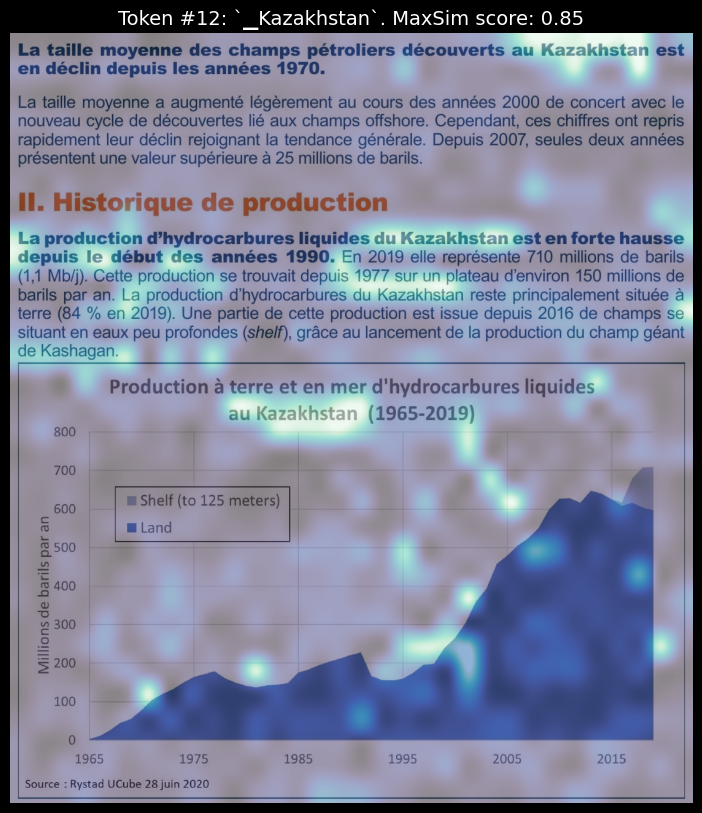

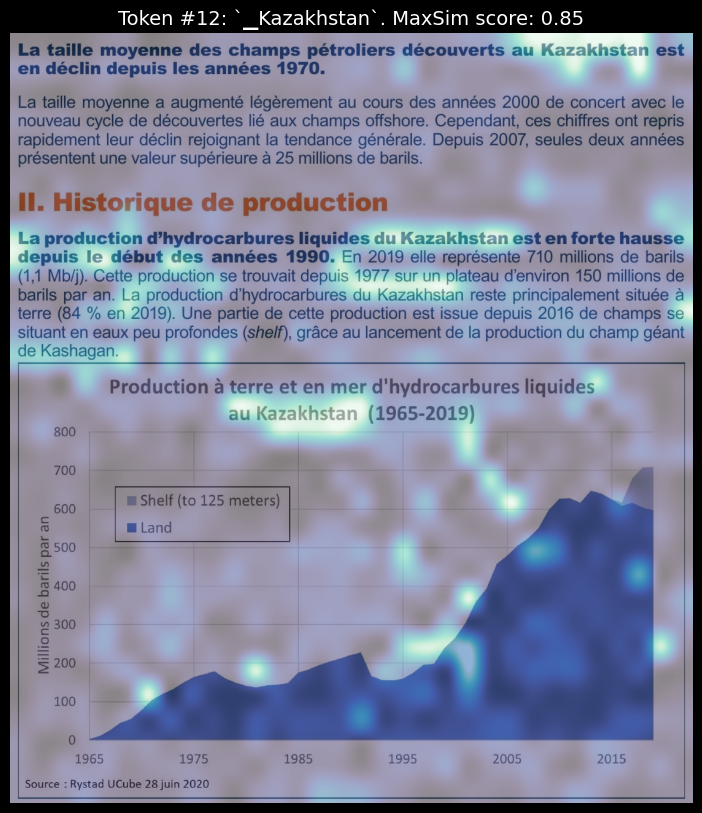

In [12]:
fig, ax = plot_similarity_map(
    image=image,
    similarity_map=current_similarity_map,
    figsize=(8, 8),  # 指定图像和相似性图的显示大小
    show_colorbar=False,
)

max_sim_score = similarity_maps[token_idx, :, :].max().item()
ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

fig

In [ ]:
plots = plot_all_similarity_maps(
    image=image,
    query_tokens=query_tokens,
    similarity_maps=similarity_maps,
    figsize=(8, 8),
    show_colorbar=False,
    add_title=True,
)

for idx, (fig, ax) in enumerate(plots):
    savepath = f"/Data/image/kazakhstan/similarity_map_{idx}.png"
    fig.savefig(savepath, bbox_inches="tight")
    print(f"Similarity map for token `{query_tokens[idx]}` saved at `{savepath}`")
 
plt.close("all")

用energy PDF  进行分析

In [5]:
# ==========================     USER INPUTS     ==========================

image_filepath = Path("/hsiam02/huotao/Data/energy_electricity_generation.jpg")
query = "Which hour of the day had the highest overall electricity generation in 2019?"
# 2019年一天中哪一个小时的总发电量最高？
# =========================================================================

assert image_filepath.is_file(), f"Cannot find the image file at `{image_filepath}`"
assert query, "Please write down your query."

image = Image.open(image_filepath)

# Preview the image
scale_image(image, 512)

(<PIL.Image.Image image mode=RGB size=722x512>, 1402, 994, 512, 722)

In [6]:
# Preprocess inputs
batch_images = processor.process_images([image]).to(device)
batch_queries = processor.process_queries([query]).to(device)

# Forward passes
with torch.no_grad():
    image_embeddings = model.forward(**batch_images)
    query_embeddings = model.forward(**batch_queries)

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


In [7]:
# Get the number of image patches
n_patches = processor.get_n_patches(image_size=image.size, patch_size=model.patch_size)

print(f"Number of image patches: {n_patches}")

# Get the tensor mask to filter out the embeddings that are not related to the image
image_mask = processor.get_image_mask(batch_images)

Number of image patches: (32, 32)


In [8]:
# Generate the similarity maps
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=image_embeddings,
    query_embeddings=query_embeddings,
    n_patches=n_patches,
    image_mask=image_mask,
)

# Get the similarity map for our (only) input image
similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)

print(f"Similarity map shape: (query_length, n_patches_x, n_patches_y) = {tuple(similarity_maps.shape)}")

Similarity map shape: (query_length, n_patches_x, n_patches_y) = (32, 32, 32)


In [9]:
# Use this cell output to choose a token using its index
query_content = processor.decode(batch_queries.input_ids[0]).replace(processor.tokenizer.pad_token, "")
query_content = query_content.replace(processor.query_augmentation_token, "").strip()
query_tokens = processor.tokenizer.tokenize(query_content)

pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

{0: '<bos>',
 1: 'Question',
 2: ':',
 3: '▁Which',
 4: '▁hour',
 5: '▁of',
 6: '▁the',
 7: '▁day',
 8: '▁had',
 9: '▁the',
 10: '▁highest',
 11: '▁overall',
 12: '▁electricity',
 13: '▁generation',
 14: '▁in',
 15: '▁',
 16: '2',
 17: '0',
 18: '1',
 19: '9',
 20: '?'}


In [10]:
# Choose a token using its index
token_idx = 4  # e.g. if "12: '▁Kazakhstan',", set 12 to choose the token 'Kazakhstan'

print(f"Selected token: `{query_tokens[token_idx]}`")

# Retrieve the similarity map for the chosen token
current_similarity_map = similarity_maps[token_idx]  # (n_patches_x, n_patches_y)

Selected token: `▁hour`


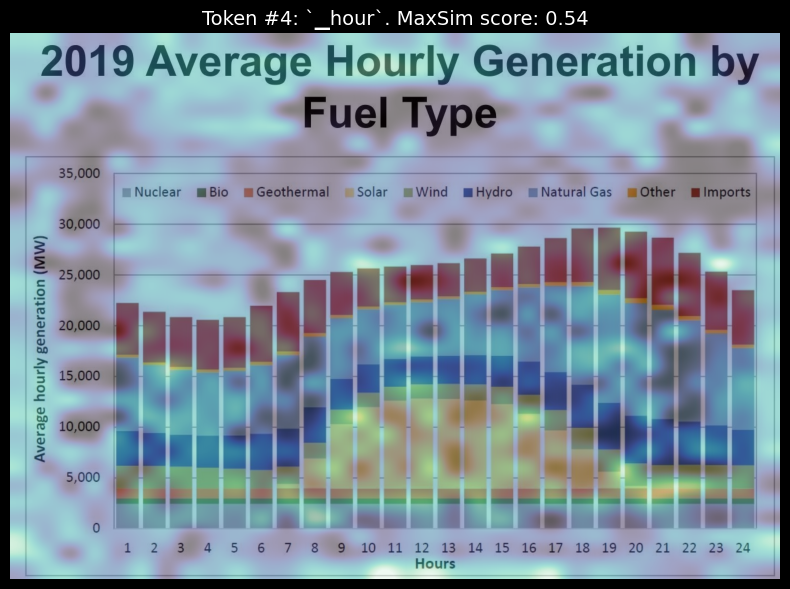

In [12]:
fig, ax = plot_similarity_map(
    image=image,
    similarity_map=current_similarity_map,
    figsize=(8, 8),
    show_colorbar=False,
)

max_sim_score = similarity_maps[token_idx, :, :].max().item()
ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

fig

In [ ]:
plots = plot_all_similarity_maps(
    image=image,
    query_tokens=query_tokens,
    similarity_maps=similarity_maps,
    figsize=(8, 8),
    show_colorbar=False,
    add_title=True,
)

for idx, (fig, ax) in enumerate(plots):
    savepath = f"/hsiam02/huotao/Data/image/energy_colpali/similarity_map_{idx}.png"
    fig.savefig(savepath, bbox_inches="tight")
    print(f"Similarity map for token `{query_tokens[idx]}` saved at `{savepath}`")

plt.close("all")